# Analysing data from multiple subjects

#### Setting up Python
We need to make sure we have our virtual environment we created during the `MNE-tutorial`.

1. Press `Select Kernel`, then `Python Environments...` and then choose any Python kernel. 
2. Run the code chunk below
3. Change the kernel used to run the code in this notebook. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

In [1]:
!bash ../env_to_ipynb_kernel.sh

Installed kernelspec env in /home/ucloud/.local/share/jupyter/kernels/env


## Importing packages

In [2]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path

# importing Lauras homemade functions for preprocessing
import sys
sys.path.append("..")
from helper_functions import preproc_subject, update_event_ids, update_events_group1_group2, event_id

## Now lets get started!

In [7]:
# dictionary with subjects and their bad channels
subjects = {
    "1": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "2": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "3": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "4": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "5": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
    "6": {"bad_channels": ['Fp1', 'Fp2'], "epochs": None},
}

# path to the data folder 
data_folder = Path("/work/EEG_lab/raw")

# loop over the subjects and preprocess their data
for subject, params in subjects.items():
    # load EEG data
    data_path = data_folder / "EEG" / f"group{subject}.vhdr"
    raw = mne.io.read_raw_brainvision(data_path)
    raw.load_data()

    # clean logfile
    logfile_path = data_folder / "behavioural" / f"subject-{subject}.csv"
    logfile = pd.read_csv(logfile_path)
    
    logfile["target_gender"] = logfile["target_gender"].apply(lambda x: x.strip())
    logfile["target_gender"] = logfile["target_gender"].apply(lambda x: x.strip("??"))

    events, _ = mne.events_from_annotations(raw)

    if subject in ["1", "2"]:
        logfile = logfile[logfile["practice"]=="no"]
        events = update_events_group1_group2(events, event_id, logfile)
    
    # preprocess the data
    epochs = preproc_subject(
        raw, 
        events = events,
        event_id = update_event_ids(events, event_id), 
        bad_channels = params["bad_channels"],
        reject = {"eeg":150e-6}, 
        l_freq = 1, 
        h_freq = 40, 
        tmin = -0.2, 
        tmax = 0.5, 
        baseline = (None, 0)
        )

    subjects[subject]["epochs"] = epochs



Extracting parameters from /work/EEG_lab/raw/EEG/group1.vhdr...
Setting channel info structure...
Reading 0 ... 531959  =      0.000 ...   531.959 secs...
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 30')]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 2 sensors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition ba

In [8]:
# concatenate all epochs
all_epochs = mne.concatenate_epochs([params["epochs"] for params in subjects.values()])

/tmp/ipykernel_20180/1859454689.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs([params["epochs"] for params in subjects.values()])


Not setting metadata
2573 matching events found
Applying baseline correction (mode: mean)


In [9]:
all_epochs

<EpochsArray | 2573 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~440.4 MB, data loaded,
 'word/prime/female/adult': 78
 'word/prime/female/child': 72
 'word/prime/female/neutral': 77
 'word/prime/male/adult': 76
 'word/prime/male/child': 70
 'word/prime/male/neutral': 75
 'word/prime/neutral/adult': 73
 'word/prime/neutral/child': 73
 'word/prime/filler': 293
 'word/target/female/congruent': 43
 and 64 more events ...>

# Analysis and plotting

Now play around with plotting of a few different contrasts. You can rely on the example below, investigating the difference between pressing the *m* and the *z* key.

In [10]:
m_epochs = all_epochs["m"]
z_epochs = all_epochs["z"]

# create the evokeds (average over trials)
m_evoked = m_epochs.average()
z_evoked = z_epochs.average()

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


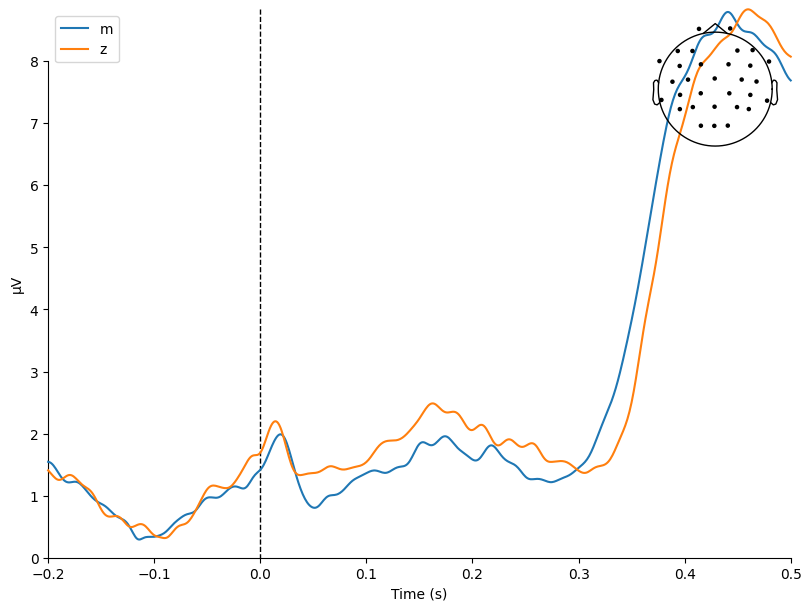

In [11]:
mne.viz.plot_compare_evokeds(dict(m=m_evoked, z=z_evoked),
                             legend='upper left', show_sensors='upper right');

Lets compare for sensors placed over the right and left motor areas (I have just eyeball'ed not verified by literature)

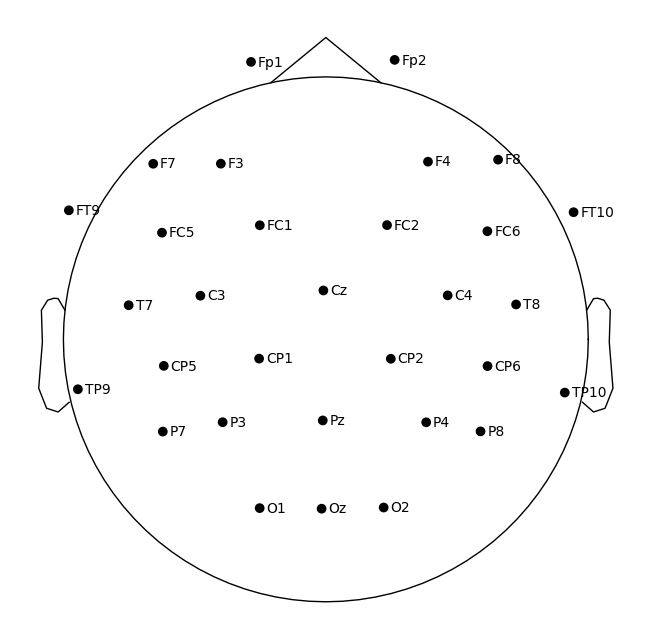

In [14]:
all_epochs.plot_sensors(show_names=True);

combining channels using "mean"
combining channels using "mean"


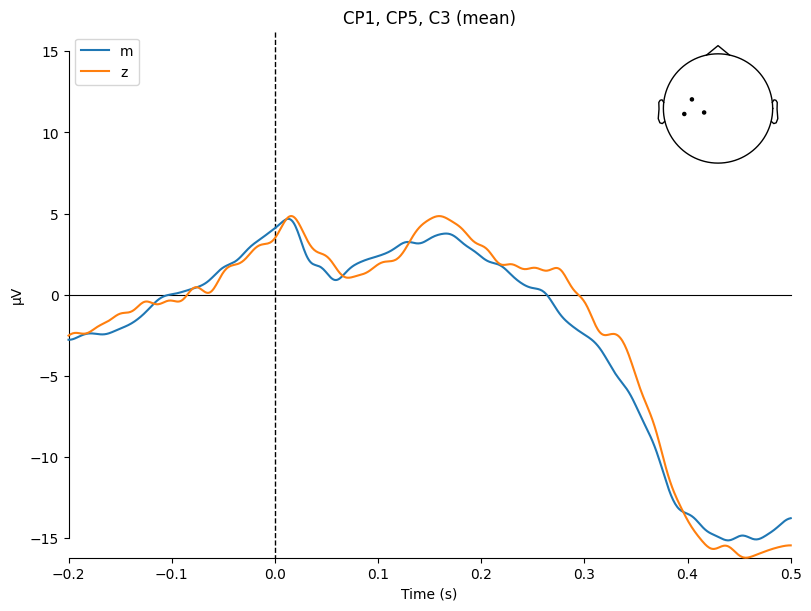

combining channels using "mean"
combining channels using "mean"


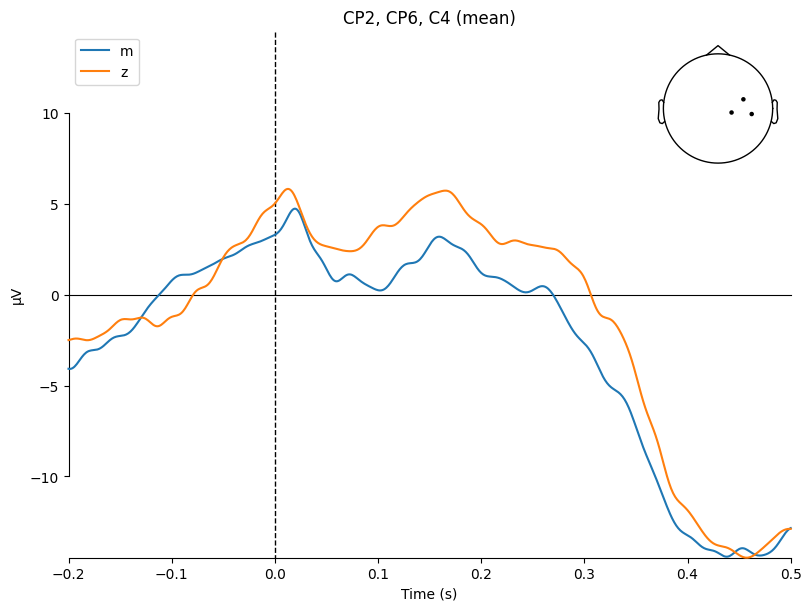

In [17]:
mne.viz.plot_compare_evokeds(
    dict(m=m_evoked, z=z_evoked),
    legend='upper left', show_sensors='upper right',
    combine = "mean", # plotting mean instead of GFP (global field power)
    picks = ["CP1", "CP5", "C3"] # sensors over left motor cortex
    );

mne.viz.plot_compare_evokeds(
    dict(m=m_evoked, z=z_evoked),
    legend='upper left', show_sensors='upper right',
    combine = "mean", # plotting mean instead of GFP (global field power)
    picks = ["CP2", "CP6", "C4"] # sensors over right motor cortex
    );